Figure 5
---

This notebook generate a purpose specific figure that includes the compares products from GrIMP with those from It'sLive. 

It is not meant to be tutorial in nature. Tutorials for the packages used to create the plots can be found [here](https://github.com/fastice/GrIMPTools).

In [1]:
%load_ext autoreload
%autoreload 2
import grimpfunc as grimp
import nisardev as nisar
import panel as pn
pn.extension()
from matplotlib import colors
#from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import os
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import dask
from dask.diagnostics import ProgressBar
ProgressBar().register()
dask.config.set(num_workers=1)
import matplotlib.gridspec as gridspec
import rioxarray
import glob
import geopandas as gpd
import xarray as xr
from shapely.geometry import Polygon
import pyproj

## Setup NSIDC Access

The following code will take the users earthdata login, create a *.netrc* file, and setup the appropriate path variabiles. Once this has been accomplished, the data at NSIDC are accessible via GDAL's *vsicurl* protocal.

In [2]:
# Set path for gdal 
env = dict(GDAL_HTTP_COOKIEFILE = os.path.expanduser('~/.grimp_download_cookiejar.txt'),
            GDAL_HTTP_COOKIEJAR = os.path.expanduser('~/.grimp_download_cookiejar.txt'))
os.environ.update(env)
# Get login
myLogin = grimp.NASALogin()  # If login appears not to work, try rerunning this cell
myLogin.view()

Getting login from ~/.netrc
Already logged in. Proceed.


## Python Routines

In [3]:
def readLive(liveFile):
    ''' Read an It's live file and return the result as 
    vx = vx component
    vy = vy component
    v =  speed
    liveData in rioxarray
    date1 = first date
    date2 = second date
    '''
    liveData = rioxarray.open_rasterio(liveFile, masked=True)
    vx = np.squeeze(liveData.vx.data).astype(float)
    vy = np.squeeze(liveData.vy.data).astype(float)
    v = np.squeeze(liveData.v.data).astype(float)
    #
    ncFile = os.path.basename(liveFile).split('_')
    date1 = datetime.strptime(os.path.basename(liveFile).split('_')[5].split('T')[0], '%Y%m%d')
    date2 = datetime.strptime(os.path.basename(liveFile).split('_')[16].split('T')[0], '%Y%m%d')
    print(date1, date2)
    return vx, vy, v, liveData, date1, date2

In [4]:
def colorSetup(scale, cmap, vmin, vmax):
    '''
    Set up normalization and color table for imshow
    Parameters
    ----------
    scale : str
        scale
    cmap : color map
        color map.
    Returns
    -------
    norm, normalization
    cmap, color ma
    '''
    if scale == 'log':
        norm = colors.LogNorm(vmin=vmin, vmax=vmax)
        # Default color map for log is truncated hsv
        if cmap is None:
            cmap = colors.LinearSegmentedColormap.from_list(
                'myMap', cm.hsv(np.linspace(0.1, 1, 250)))
        return norm, cmap
    # Pass back colormap for linear case
    elif scale == 'linear':
        return colors.Normalize(vmin=vmin, vmax=vmax), cmap

## It's Live Files

Use It'sLive data from Lei et al, 2021, Figure 2, since presumably these data have been well vetted and represent something approaching best case. The data were download from https://doi.org/10.5281/zenodo.5606118. 

In [5]:
liveFile = 'ItsLiveData/S1B_IW_SLC__1SSH_20170404T204604_20170404T204631_005016_008C58_5527_X_S1A_IW_SLC__1SSH_20170410T204646_20170410T204713_016087_01A8F8_2577_G0120V02_P098.nc'

In [6]:
vx, vy, v, liveData, date1, date2 = readLive(liveFile)
midDate = date1 + (date2-date1)*.5
midDate
liveExtent = np.array([min(liveData.x).item(), max(liveData.x).item(), min(liveData.y).item(), max(liveData.y).item()]) * 0.001

2017-04-04 00:00:00 2017-04-10 00:00:00


Get bounding box for region.

In [7]:
bbox = {}
bbox['minx'] =min(liveData.x).item() 
bbox['maxx'] =max(liveData.x).item()
bbox['miny'] =min(liveData.y).item() 
bbox['maxy'] =max(liveData.y).item() 
bbox

{'minx': -375067.5, 'maxx': -72187.5, 'miny': -2462212.5, 'maxy': -2082652.5}

## GrIMP Files

Get the 6 day map. Note the mosaic covers the standard period (April 2-7, 2017), with all pairs with central dates lying in that period. For this area, there is one date take, which covers April 4-10, 2017.

### GrIMP 6 Day Product

Find the closest 6-day product.

In [8]:
# Search for same data
myUrls = grimp.cmrUrls(mode='nisar')  # mode image restricts search to the image products
myUrls.initialSearch(firstDate=midDate.strftime('%Y-%m-%d'), lastDate=midDate.strftime('%Y-%m-%d'), product='NSIDC-0766', productFilter=None);
myUrls.getCogs(replace='vv', removeTiff=True)

['https://n5eil01u.ecs.nsidc.org/DP4/MEASURES/NSIDC-0766.001/2017.04.02/GL_vel_mosaic_s1cycle_02Apr17_07Apr17_*_v01.0']

Download the data.

In [9]:
GrIMP6Day = nisar.nisarVelSeries() # Create Series
GrIMP6Day.readSeriesFromTiff( myUrls.getCogs(replace='vv', removeTiff=True), url=True, readSpeed=False) 
GrIMP6Day.subSetVel(bbox)
GrIMP6Day.loadRemote()

[########################################] | 100% Completed | 16.7s


### GrIMP Annual Product

Read and load the Annual map for that year.

In [10]:
myUrlsAnnual = grimp.cmrUrls(mode='nisar')  # mode image restricts search to the image products
myUrlsAnnual.initialSearch(firstDate=midDate.strftime('%Y-%m-%d'), lastDate=midDate.strftime('%Y-%m-%d'), product='NSIDC-0725', productFilter=None);

In [11]:
GrIMPAnnual = nisar.nisarVelSeries() # Create Series
GrIMPAnnual.readSeriesFromTiff(myUrlsAnnual.getCogs(replace='vv', removeTiff=True), url=True, readSpeed=False) 
GrIMPAnnual.subSetVel(bbox)
GrIMPAnnual.loadRemote()

[########################################] | 100% Completed | 30.4s


### Shape File Showing Swath 
First pull shape file showing data coverage.Coverage

Read the shapefile.

In [12]:
# Loop over list of urls
for url in myUrls.getURLS():
    url = myUrls.getCogs(replace='vv', removeTiff=True)[0].replace('*', 'SAR') + '.shp'
    print(url)
    myShapes = gpd.read_file(f'/vsicurl/&url={url}')  # Add terminus to data frame

https://n5eil01u.ecs.nsidc.org/DP4/MEASURES/NSIDC-0766.001/2017.04.02/GL_vel_mosaic_s1cycle_02Apr17_07Apr17_SAR_v01.0.shp


Convert coordinates to epsg 3413 (polar stereo) in units of km and save in dictionary `frames`.

In [13]:
xytoll = pyproj.Transformer.from_crs( 3413, 4326)
lltoxy = pyproj.Transformer.from_crs( 4326,  3413)
lat, lon = xytoll.transform([bbox['minx'], bbox['minx'], bbox['maxx'], bbox['maxx'], bbox['minx']], [bbox['miny'], bbox['maxy'], bbox['maxy'], bbox['miny'], bbox['miny']])
myBox = Polygon(zip(lon,lat))
boxShapes = myShapes.loc[myShapes['geometry'].intersects(myBox)]
frames = {}
for index, row in boxShapes.iterrows():
    latB, lonB = row['geometry'].exterior.coords.xy
    xF, yF = np.array(lltoxy.transform(lonB, latB))
    xF *= 0.001
    yF *= 0.001
    frames[index] = {'x': xF, 'y': yF}

## Generate Plot

Dictionary with plot parameters for each line used as a profile plot.

In [28]:
#
lines = {'line1': {'y': -2.4e6, 'x1': -235e3, 'x2': -85e3, 'ymax': 200, 'color': 'w', 'index': 0, 
                   'orientation': 'horizontal', 'lineColor': 'k', 'name': 'A'},
         'line2': {'y': -2.215e6, 'x1': -200e3, 'x2': -105e3, 'ymax': 200, 'color': 'k', 'index': 1,
                   'orientation': 'horizontal', 'lineColor': 'magenta', 'name': 'B'},
         'line3': {'x': -114e3, 'y1': -2.35e6, 'y2': -2.16e6, 'ymax': 500, 'color': 'r', 'index': 2,
                   'orientation': 'vertical', 'lineColor': 'darkorange', 'name': 'C'}
        }
dx = {'horizontal': 10, 'vertical': 0}  # Offsets for text labels
dy = {'horizontal': 0, 'vertical': 10}
labels = {'Jak': {'xc': -202,'yc': -2275}}

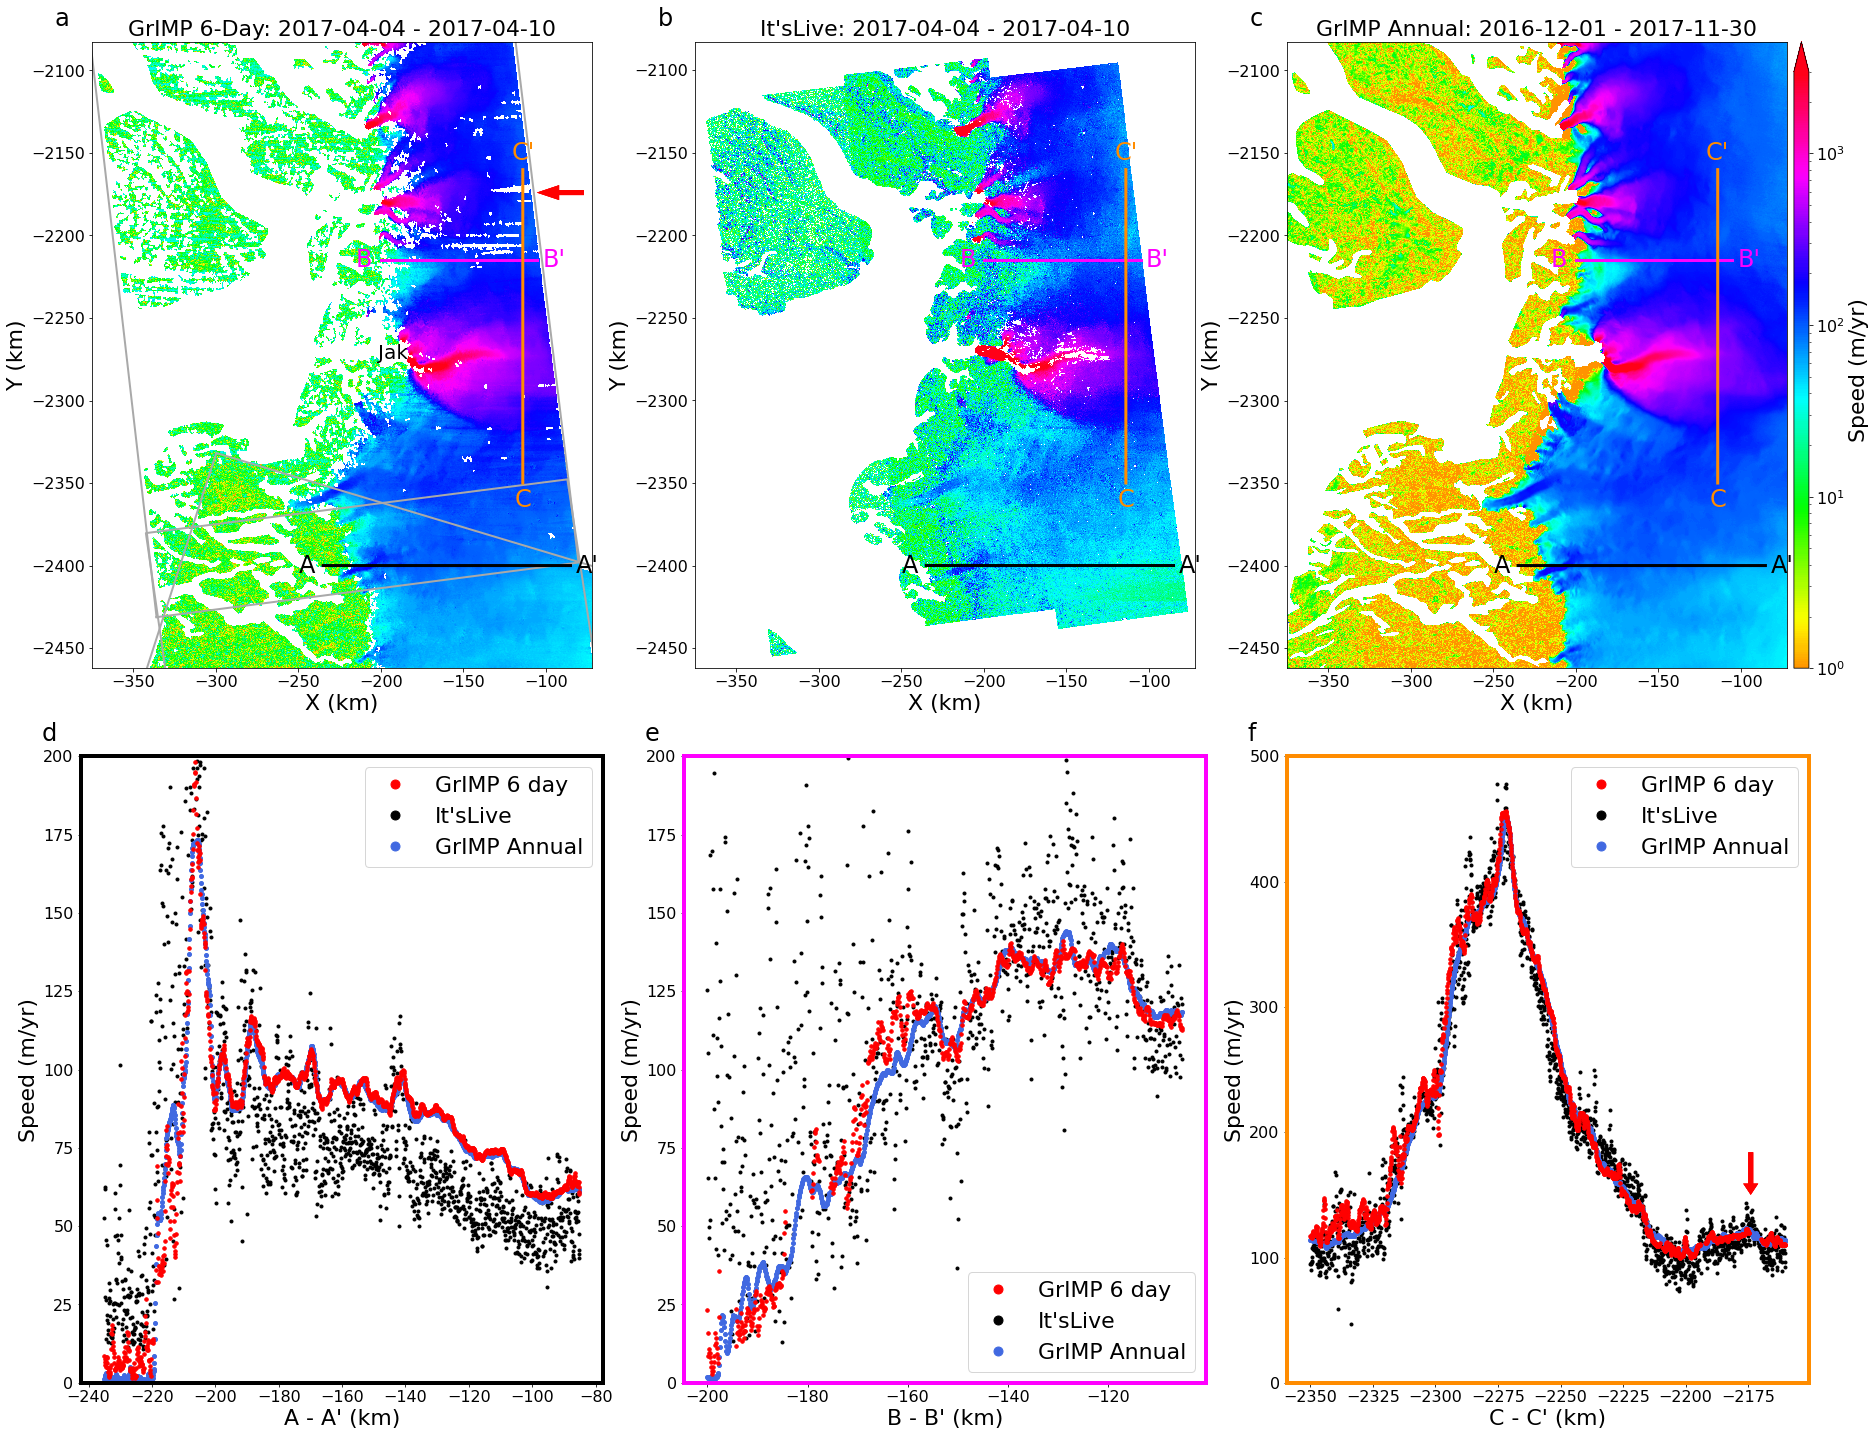

In [29]:
# Create 2 row by 3 col figure
fig, axes = plt.subplots(2, 3, figsize=(26, 20))
# Color scale range
minv, maxv= 1, 3000  # Color bar range
norm, cmap = colorSetup('log', 'hsv', minv, maxv)  # Match color bar 
titleFontSize=22  # Font sizes
labelFontSize=22
tickFontSize=16
#
# Display It's Live Data
axes[0, 1].imshow(v, norm=norm, cmap=cmap, extent=liveExtent, interpolation='nearest')
myTitle = f'{date1.strftime("%Y-%m-%d")} - {date2.strftime("%Y-%m-%d")}'
axes[0, 1].set_title(f'It\'sLive: {myTitle}', fontsize=titleFontSize)
axes[0, 1].set_xlabel('X (km)', fontsize=labelFontSize)
axes[0, 1].set_ylabel('Y (km)', fontsize=labelFontSize)
axes[0, 1].tick_params(axis='both', labelsize=tickFontSize)
#
# Display 6-day
GrIMP6Day.displayVelForDate(ax=axes[0, 0], vmin=minv, vmax=maxv, interpolation='nearest', scale='log', 
                            midDate=False, colorBar=None, units='km', title=f'GrIMP 6-Day: {myTitle}', 
                            titleFontSize=titleFontSize, plotFontSize=tickFontSize, labelFontSize=labelFontSize)
for label in labels:
    axes[0, 0].text(labels[label]['xc'], labels[label]['yc'], label, fontsize=20) 
#
# Plot swath outlines on 6-day product
for index, frame in frames.items():
    axes[0, 0].plot(frame['x'], frame['y'], color='darkgray', linewidth=2)
gBox = GrIMP6Day.boundingBox(units='km')
axes[0, 0].set_xlim(gBox['minx'], gBox['maxx'])
axes[0, 0].set_ylim(gBox['miny'], gBox['maxy'])
#
# Display Annual data
myAnnualTitle = f'GrIMP Annual: {GrIMPAnnual.time1[0].strftime("%Y-%m-%d")} - {GrIMPAnnual.time2[0].strftime("%Y-%m-%d")}'
GrIMPAnnual.displayVelForDate(ax=axes[0, 2], vmin=minv, vmax=maxv, interpolation='nearest', scale='log', 
                              midDate=False, units='km', title=myAnnualTitle, titleFontSize=titleFontSize,
                              plotFontSize=tickFontSize, labelFontSize=labelFontSize, colorBarSize='3%', colorBarPad=.1)
#
# Plot lines AA'...
for key, line in lines.items():
    # S
    if line['orientation'] == 'horizontal':
        x = np.arange(line['x1'], line['x2'], 100)
        y =  np.ones(x.shape) * line['y']
        plotCoord = x * 0.001
    else:
        y = np.arange(line['y1'], line['y2'], 100)
        x =  np.ones(y.shape) * line['x']
        plotCoord = y * 0.001
    #
    # Plot lines
    labels = []
    for i in range(0, 3):
        axes[0,i].plot(x * 0.001, y * 0.001, linewidth=3, color=line['lineColor'])
        # Plot line labels
        axes[0,i].text(x[0] * 0.001 - dx[line['orientation']], y[0] * 0.001 -dy[line['orientation']], line['name'],  
                       fontsize=24, color=line['lineColor'],ha='center', va='center')
        axes[0,i].text(x[-1] * 0.001 + dx[line['orientation']], y[-1] * 0.001 + dy[line['orientation']], f'{line["name"]}\'',
                       fontsize=24, color=line['lineColor'],ha='center', va='center')   
    #
    # Interpolate It's Live data
    result = liveData.interp(x=xr.DataArray(x), y=xr.DataArray(y), method='linear')
    vpLive = np.squeeze(result.v.data)   #
    #
    # Interpolate GrIMP data
    vGrIMP6Day = GrIMP6Day.interp(x, y, returnXR=True)
    vGrIMPAnnual = GrIMPAnnual.interp(x, y, returnXR=True)
    #
    # Plot data along line
    axes[1, line['index']].plot(plotCoord, vpLive, 'k.', label='It\'sLive')  # It's Live
    axes[1, line['index']].plot(plotCoord, np.squeeze(vGrIMPAnnual.sel(band='vv')), '.', label='GrIMP Annual', color='royalblue', markersize=8)  # Grimp
    axes[1, line['index']].plot(plotCoord, np.squeeze(vGrIMP6Day.sel(band='vv')), 'r.', label='GrIMP 6 day', markersize=7)
    #
    axes[1, line['index']].set_ylim((0, line['ymax']))
    #
    handles, labels = axes[1, line['index']].get_legend_handles_labels()
    myOrder = [2, 0, 1]  # Key legend in same order as top row of figures
    lgnd = axes[1, line['index']].legend([handles[i] for i in myOrder], [labels[i] for i in myOrder], fontsize=labelFontSize)
    #
    # make legend marker larger so color distinguishable
    for l in lgnd.legendHandles:
        l.set_markersize(18)
    # set tick params and labels
    axes[1, line['index']].tick_params(axis='both', labelsize=tickFontSize)
    axes[1, line['index']].set_xlabel(f'{line["name"]} - {line["name"]}\' (km)', fontsize=labelFontSize)
    axes[1, line['index']].set_ylabel('Speed (m/yr)', fontsize=labelFontSize)
    # Color plotoutline by linear color
    for pos in ['bottom', 'top', 'left', 'right']:
        axes[1, line['index']].spines[pos].set_color(line['lineColor'])
        axes[1, line['index']].spines[pos].set_linewidth(4)
    #
    axes[0, 0].arrow(x=-77, y=-2174, dx=-15, dy=0, width=3, facecolor='red', edgecolor='none') 
    axes[1, 2].arrow(y=184, x=-2174, dx=0, dy=-25, width=2, facecolor='red', edgecolor='none')
# add letters for panels
for ax, letter in zip(axes.flatten(), ['a', 'b', 'c', 'd', 'e', 'f']):
    ax.text(-0.075,1.025, letter, fontsize=24, transform=ax.transAxes)
fig.tight_layout()  
fig.savefig('Figure5.jpg', dpi=200,  bbox_inches='tight')

## 